In [1]:
import sys
PATH_FOR_PROJECT = "/home/louis/Dropbox/ConsultationSimpliphAI/AnalytiqueBourassaGit/LSTM_BayesRegressor/"
sys.path.append(PATH_FOR_PROJECT)

In [2]:
from tqdm import tqdm

In [3]:
from uncertainty_forecasting.models.training_tools.early_stopping import EarlyStopping
from dataclasses import dataclass

@dataclass
class ExperimentParameters:

    path: str = "/"
    version: str = "v0.0.4"
    show_figures: bool = True
    smoke_test: bool = False
    train_lstm: bool = True
    save_lstm: bool = False
    type_of_data: str = "sinus"
    name: str = "feature_extractor"

In [4]:
PATH_LOCAL = "models/"

In [5]:
early_stopper = EarlyStopping(patience=4, verbose=True)

experiment_params = ExperimentParameters()
experiment_params.path = PATH_FOR_PROJECT + "/examples/.models/"
experiment_params.version = "v0.0.7"
experiment_params.show_figures = False
experiment_params.smoke_test = False
experiment_params.train_lstm = True
experiment_params.save_lstm = True
experiment_params.type_of_data = "autoregressive-5" # options are sin or "autoregressive-5"
experiment_params.name = "feature_extractor_" + experiment_params.type_of_data

In [6]:
n_data = 1000
length_of_sequences = 7 + 1

# 2. Data generation

In [7]:
from math import floor

In [8]:
from uncertainty_forecasting.data_generation.data_generators_switcher import DatageneratorsSwitcher
from uncertainty_forecasting.data_handling.data_reshaping import reshape_data_for_LSTM, reshape_into_sequences
from uncertainty_forecasting.visualisations.visualisations import Visualisator

In [9]:
size_of_training_set = 0.5
size_of_training_and_val_set = 0.7

In [10]:
data_generator = DatageneratorsSwitcher(experiment_params.type_of_data)
data = data_generator(n_data)

sequences = reshape_into_sequences(data, length_of_sequences)
all_data = reshape_data_for_LSTM(sequences)

training_data_labels = all_data[length_of_sequences-1, :, 0]

number_of_train_data = floor(size_of_training_set*n_data)
val_set_end = floor(size_of_training_and_val_set*n_data)

data_train = all_data[:, :number_of_train_data, :]
data_validation = all_data[:, number_of_train_data:val_set_end, :]

if experiment_params.show_figures:
    Visualisator.show_time_series(data=all_data[length_of_sequences-2, :, 0],
                                  title="Data generated using an ARMA(4,2) process")

# 3. Training of the feature extractor (LSTM)

In [11]:
from uncertainty_forecasting.models.lstm_params import LSTM_parameters
from uncertainty_forecasting.models.regression.LSTM_BayesRegressor.LSTM import LSTM

In [12]:
from uncertainty_forecasting.models.model_data_feeder import *
from uncertainty_forecasting.models.disk_reader_and_writer import save_checkpoint, load_checkpoint

In [13]:
from sklearn.metrics import mean_squared_error

In [14]:
lstm_params = LSTM_parameters()

if experiment_params.train_lstm is False:
    lstm_params.load("lstm_params_" + experiment_params.name + "_" + experiment_params.version, experiment_params.path)
    
lstm_params.batch_size = 50
lstm_params.hidden_dim = 5
lstm_params.dropout = 0.4

In [15]:
learning_rate = 1e-3
num_epochs = 2300 if not experiment_params.smoke_test else 1
epoch_interval_for_loss_tracking =100

In [16]:
model = LSTM(lstm_params)
model.cuda()

/home/louis/anaconda3/envs/env_UncertaintyForecasting/lib/python3.6/site-packages/torch/nn/modules/rnn.py:54: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


LSTM(
  (lstm): LSTM(1, 5, dropout=0.4)
  (linear): Linear(in_features=5, out_features=1, bias=True)
)

In [17]:
loss_fn = torch.nn.MSELoss(size_average=False)
optimizer = torch.optim.Adam(model.parameters(),
                             lr=learning_rate)

/home/louis/anaconda3/envs/env_UncertaintyForecasting/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [18]:
if experiment_params.train_lstm:
    hist = np.zeros(num_epochs)
    for epoch in tqdm(range(num_epochs)):
        model.hidden = model.init_hidden()

        losses, N_data = make_forward_pass(data_loader_sequences, model, loss_fn, data_train, lstm_params.batch_size)

        if epoch % epoch_interval_for_loss_tracking == 0:
            y_pred, y_true = make_predictions(data_loader_sequences, model, data_validation, lstm_params.batch_size)
            val_loss = mean_squared_error(y_pred, y_true)
            print("Epoch ", epoch, "MSE: ", val_loss)
            early_stopper(epoch, val_loss, model)

            if early_stopper.early_stop:
                break

        hist[epoch] = losses.item()

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
else:

    load_checkpoint(model, optimizer, experiment_params.path,
                    experiment_params.name + "_" + experiment_params.version)

if experiment_params.save_lstm:
    save_checkpoint(model, optimizer, experiment_params.path,
                    experiment_params.name + "_" + experiment_params.version)
    lstm_params.save(experiment_params.version, experiment_params.path)

y_pred, _ = make_predictions(data_loader_sequences, model, all_data, lstm_params.batch_size)
features, y_true = extract_features(data_loader_sequences, model, all_data, lstm_params.batch_size)

  1%|          | 16/2300 [00:00<00:31, 73.02it/s]

Epoch  0 MSE:  0.0836782


  5%|▍         | 106/2300 [00:01<00:33, 65.84it/s]

Epoch  100 MSE:  0.0721105


  9%|▉         | 209/2300 [00:03<00:40, 51.65it/s]

Epoch  200 MSE:  0.0655959


 13%|█▎        | 305/2300 [00:04<00:33, 59.83it/s]

Epoch  300 MSE:  0.0598582


 18%|█▊        | 410/2300 [00:06<00:28, 66.21it/s]

Epoch  400 MSE:  0.0542139


 22%|██▏       | 511/2300 [00:08<00:31, 56.21it/s]

Epoch  500 MSE:  0.0523689


 26%|██▋       | 608/2300 [00:09<00:32, 52.57it/s]

Epoch  600 MSE:  0.0525391
EarlyStopping counter: 1 out of 4


 31%|███       | 717/2300 [00:11<00:19, 81.86it/s]

Epoch  700 MSE:  0.0519839


 35%|███▌      | 816/2300 [00:12<00:18, 80.54it/s]

Epoch  800 MSE:  0.0511698


 40%|███▉      | 915/2300 [00:13<00:16, 84.99it/s]

Epoch  900 MSE:  0.0504151


 44%|████▍     | 1014/2300 [00:14<00:15, 83.99it/s]

Epoch  1000 MSE:  0.0499788


 48%|████▊     | 1113/2300 [00:15<00:14, 84.74it/s]

Epoch  1100 MSE:  0.049799


 53%|█████▎    | 1212/2300 [00:17<00:13, 81.25it/s]

Epoch  1200 MSE:  0.0497308


 57%|█████▋    | 1311/2300 [00:18<00:11, 83.49it/s]

Epoch  1300 MSE:  0.0496976


 61%|██████▏   | 1410/2300 [00:19<00:10, 82.65it/s]

Epoch  1400 MSE:  0.0496718


 66%|██████▌   | 1509/2300 [00:20<00:09, 85.32it/s]

Epoch  1500 MSE:  0.0496457


 70%|███████   | 1617/2300 [00:21<00:08, 82.10it/s]

Epoch  1600 MSE:  0.0496184


 75%|███████▍  | 1716/2300 [00:23<00:07, 81.63it/s]

Epoch  1700 MSE:  0.0495919


 79%|███████▉  | 1815/2300 [00:24<00:05, 82.52it/s]

Epoch  1800 MSE:  0.0495712


 83%|████████▎ | 1914/2300 [00:25<00:04, 82.04it/s]

Epoch  1900 MSE:  0.0495641


 88%|████████▊ | 2013/2300 [00:26<00:03, 83.30it/s]

Epoch  2000 MSE:  0.049584
EarlyStopping counter: 1 out of 4


 92%|█████████▏| 2112/2300 [00:27<00:02, 83.12it/s]

Epoch  2100 MSE:  0.0496541
EarlyStopping counter: 2 out of 4


 96%|█████████▌| 2211/2300 [00:29<00:01, 82.93it/s]

Epoch  2200 MSE:  0.049788
EarlyStopping counter: 3 out of 4


100%|██████████| 2300/2300 [00:30<00:00, 76.18it/s]


# 4. Results of feature extractor

In [19]:
from sklearn.metrics import r2_score

In [20]:
print("r2 score: %.4f" % r2_score(y_true.flatten(), y_pred.flatten()))
print("r2 score for naive forecaster: %.4f" % r2_score(y_true[1:].flatten(), y_true[:-1].flatten()))

r2 score: 0.5391
r2 score for naive forecaster: 0.3473


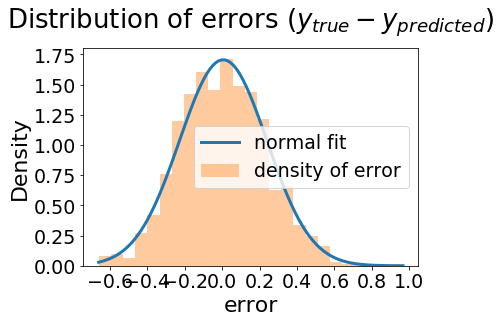

In [21]:
errors = y_true.flatten() - y_pred.flatten()

Visualisator.show_distribution(data=errors,
                               title="Distribution of errors ($y_{true} - y_{predicted}$)",
                               normal_fit=True,
                               name="error")

In [22]:
if experiment_params.show_figures:
    Visualisator.show_predictions(y_pred, y_true)

    if experiment_params.train_lstm:
        Visualisator.show_epoch_convergence(data=hist,
                                            name="Loss",
                                            title="Loss convergence curve for the LSTM training")


# 5. Probabilistic model

In [23]:
from uncertainty_forecasting.models.regression.LSTM_BayesRegressor.bayesian_linear_regression.bayesian_linear_regression import BayesianLinearModel

Can not use cuDNN on context None: cannot compile with cuDNN. We got this error:
b'/tmp/try_flags_u67wmkhd.c:4:10: fatal error: cudnn.h: No such file or directory\n #include <cudnn.h>\n          ^~~~~~~~~\ncompilation terminated.\n'
ERROR (theano.gpuarray): Could not initialize pygpu, support disabled
Traceback (most recent call last):
  File "/home/louis/anaconda3/envs/env_UncertaintyForecasting/lib/python3.6/site-packages/theano/gpuarray/__init__.py", line 227, in <module>
    use(config.device)
  File "/home/louis/anaconda3/envs/env_UncertaintyForecasting/lib/python3.6/site-packages/theano/gpuarray/__init__.py", line 214, in use
    init_dev(device, preallocate=preallocate)
  File "/home/louis/anaconda3/envs/env_UncertaintyForecasting/lib/python3.6/site-packages/theano/gpuarray/__init__.py", line 140, in init_dev
    context.free_gmem / MB))
RuntimeError: Trying to preallocate 3843 MB of GPU memory while only 2678 MB are available.


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, thetas, theta_0]
Sampling 4 chains: 100%|██████████| 44000/44000 [07:19<00:00, 100.06draws/s]
The acceptance probability does not match the target. It is 0.887788136365, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


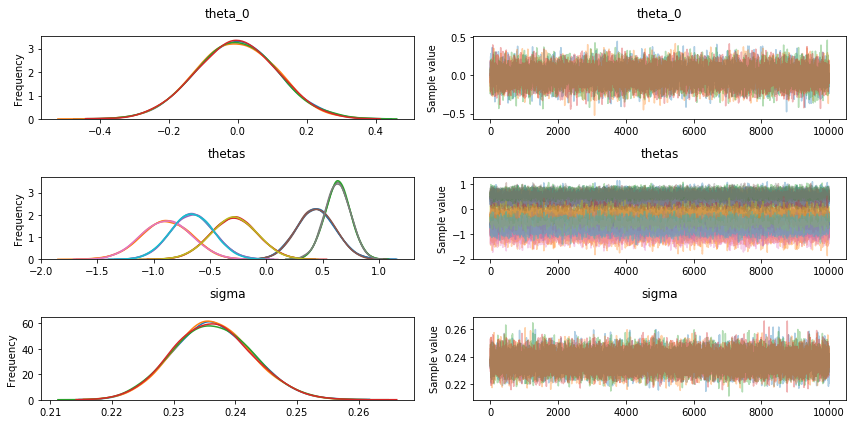

100%|██████████| 1000/1000 [00:10<00:00, 102.30it/s]


In [24]:
number_of_train_data = floor(size_of_training_and_val_set*n_data)
X_train, X_test, y_train, y_test = features[:number_of_train_data], features[number_of_train_data:], \
                                   y_true[:number_of_train_data], y_true[number_of_train_data:]

model.cpu()
priors_beta, _ = model.last_layers_weights

model_linear_mcmc = BayesianLinearModel(X_train,
                                        y_train,
                                        priors_beta,
                                        SMOKE_TEST=experiment_params.smoke_test)

model_linear_mcmc.option = "NUTS"
model_linear_mcmc.sample()
model_linear_mcmc.show_trace()

predictions = model_linear_mcmc.make_predictions(X_test, y_test)

# 6. Analysis of probabilistic predictions

In [25]:
from uncertainty_forecasting.models.calibration.analysis import show_analysis
from uncertainty_forecasting.models.calibration.diagnostics import *

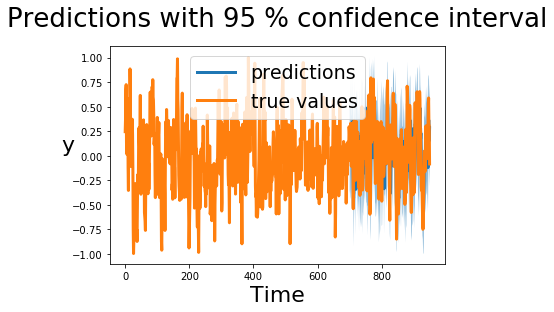

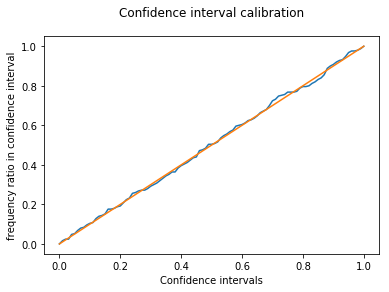

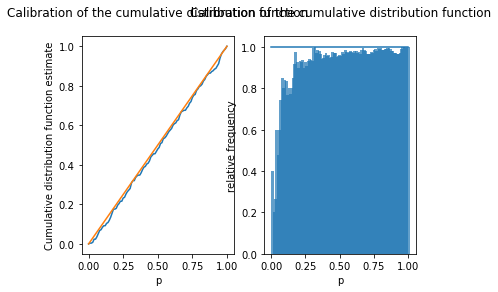

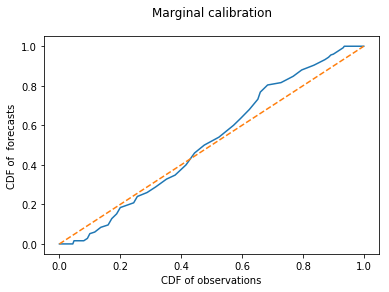

 deviation_score_probabilistic_calibration: 0.00820 
 deviation_score_exceedance_calibration: 0.01492 
 deviation_score_marginal_calibration: 0.04661 


In [26]:
deviation_score_probabilistic_calibration = calculate_confidence_interval_calibration(predictions.values, predictions.true_values)
deviation_score_exceedance_calibration = calculate_one_sided_cumulative_calibration(predictions.values, predictions.true_values)
deviation_score_marginal_calibration = calculate_marginal_calibration(predictions.values, predictions.true_values)

predictions.train_data = y_train
predictions.show_predictions_with_training_data(confidence_interval=0.95)

show_analysis(predictions.values, predictions.true_values, name="LSTM + " + model_linear_mcmc.option)